$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/y.chen/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/y.chen/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/y.chen/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


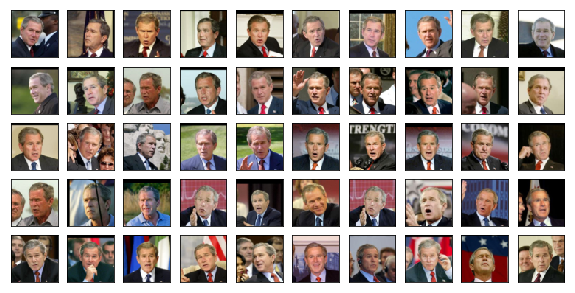

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_encode): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv2d(256, 1024, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (13): MaxPool2d(kerne

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (ln_rec): Linear(in_features=128, out_features=16384, bias=True)
  (features_decoder): DecoderCNN(
    (cnn): Sequential(
      (0): ReLU()
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Upsample(scale_factor=2, mode=bilinear)
      (3): Conv2d(1024, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Upsample(scale_factor=2, mode=bilinear)
      (7): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (8): ReLU()
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Upsample(scale_factor=2, mode=bilinear)
      (11): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (12): ReLU()
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Upsample(scale_fact

/home/y.chen/miniconda3/envs/cs236605-hw/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/y.chen/miniconda3/envs/cs236605-hw/lib/python3.7/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


/home/y.chen/miniconda3/envs/cs236605-hw/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients.

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

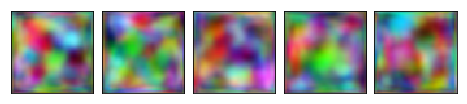

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 32, 'data_label': 1, 'label_noise': 0.5, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0001, 'weight_decay': 0.001}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0001, 'weight_decay': 0.001}}


--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.18it/s]
Discriminator loss: 0.665591208373799
Generator loss:     2.3431650400161743


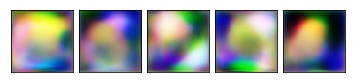

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
Discriminator loss: 0.2863674935172586
Generator loss:     4.083750247955322


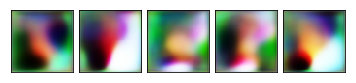

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.08it/s]
Discriminator loss: 0.1929442304022172
Generator loss:     4.673793526256786


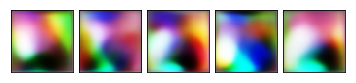

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.99it/s]
Discriminator loss: -0.053004746489665085
Generator loss:     5.5955470029045555


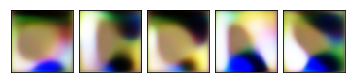

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.49it/s]
Discriminator loss: -0.015169467996148503
Generator loss:     6.062840798321893


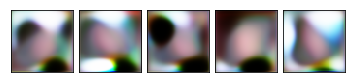

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.40it/s]
Discriminator loss: 0.019182535655358258
Generator loss:     7.249737234676585


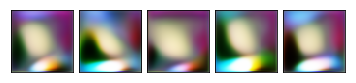

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: -0.11012538380044348
Generator loss:     8.21740088743322


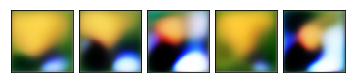

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.52it/s]
Discriminator loss: 0.035664471195024604
Generator loss:     8.10509303036858


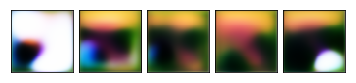

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: -0.018163188853684592
Generator loss:     8.468778722426471


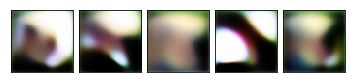

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: -0.024105964776347664
Generator loss:     8.386213386760039


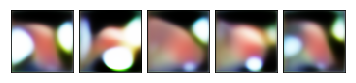

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: 0.05831228722544277
Generator loss:     7.85639269211713


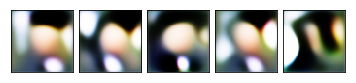

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.50it/s]
Discriminator loss: 0.11592234835466918
Generator loss:     8.504676145665785


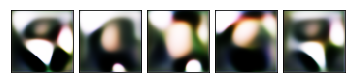

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
Discriminator loss: -0.04945676160209319
Generator loss:     8.970325554118437


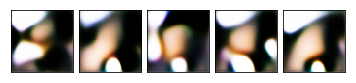

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: -0.10393608021823798
Generator loss:     8.230159871718463


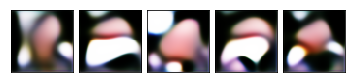

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.01it/s]
Discriminator loss: 0.20741683945936315
Generator loss:     7.4191092883839325


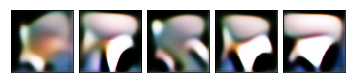

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: -0.02840136123054168
Generator loss:     9.303709114299101


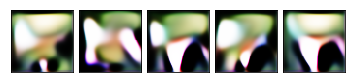

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.06it/s]
Discriminator loss: 0.039668788147323275
Generator loss:     8.299091703751508


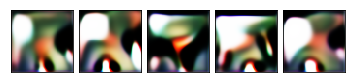

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.05it/s]
Discriminator loss: 0.10123807783512508
Generator loss:     6.9044049767886895


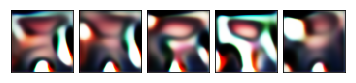

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.52it/s]
Discriminator loss: 0.07416567622738726
Generator loss:     8.073924232931699


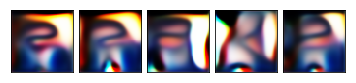

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 0.09951188108500313
Generator loss:     8.827511338626637


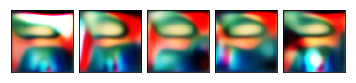

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.46it/s]
Discriminator loss: -0.032672519412110836
Generator loss:     6.8183479870066925


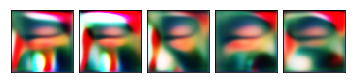

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.29it/s]
Discriminator loss: -0.026338994174319154
Generator loss:     8.687284553752226


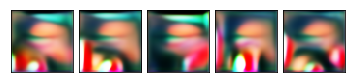

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.36it/s]
Discriminator loss: -0.005469306865159203
Generator loss:     9.03015251720653


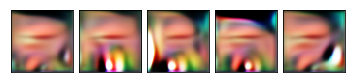

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.49it/s]
Discriminator loss: 0.17202730433029287
Generator loss:     9.537726766922894


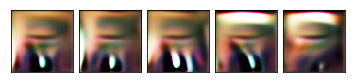

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.50it/s]
Discriminator loss: 0.15245305440005133
Generator loss:     8.151815077837776


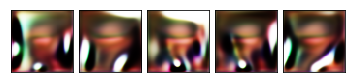

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
Discriminator loss: 0.0770076150622438
Generator loss:     7.722934386309455


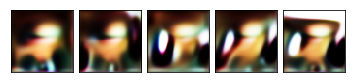

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: 0.11119510233402252
Generator loss:     6.263515219968908


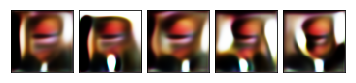

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
Discriminator loss: -0.017324350007316646
Generator loss:     6.13984624077292


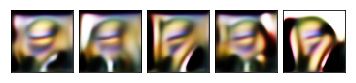

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.05it/s]
Discriminator loss: 0.0380115223062389
Generator loss:     7.720717009376077


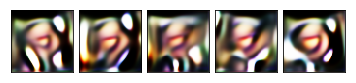

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.06it/s]
Discriminator loss: 0.15291381189051798
Generator loss:     8.588446294560152


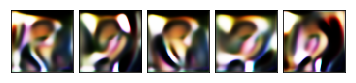

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.31it/s]
Discriminator loss: 0.24672520314069354
Generator loss:     7.837055444717407


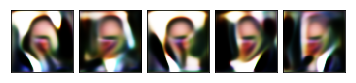

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.59it/s]
Discriminator loss: 0.0960334331235465
Generator loss:     6.942128405851476


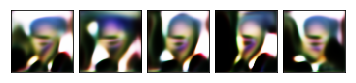

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.52it/s]
Discriminator loss: 0.08444554621682447
Generator loss:     5.85062697354485


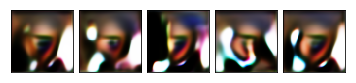

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 0.005215063691139221
Generator loss:     9.078670698053697


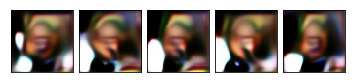

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: -0.010717516874565798
Generator loss:     7.793759963091682


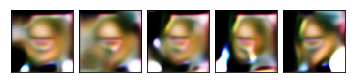

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 0.15688405974822886
Generator loss:     8.344012344584746


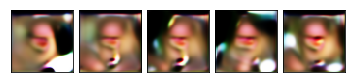

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.44it/s]
Discriminator loss: 0.046054218621814955
Generator loss:     6.3486772986019355


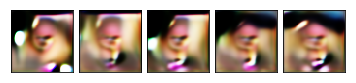

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 0.10395300234941875
Generator loss:     6.421184034908519


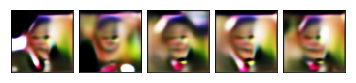

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.46it/s]
Discriminator loss: 0.14793037469772732
Generator loss:     6.004163223154404


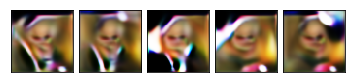

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.42it/s]
Discriminator loss: 0.21047393221627264
Generator loss:     6.4160480779760025


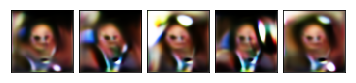

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.59it/s]
Discriminator loss: 0.12729758352917783
Generator loss:     8.197409643846399


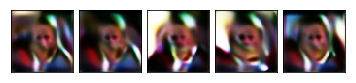

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 0.0952007376095828
Generator loss:     6.107181675293866


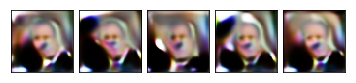

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.52it/s]
Discriminator loss: 0.147759259404505
Generator loss:     6.783079820520737


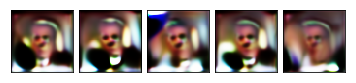

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 0.06832839614328216
Generator loss:     7.6897071389591


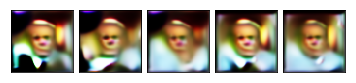

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: -0.08225327686351888
Generator loss:     8.949194431304932


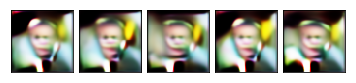

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.43it/s]
Discriminator loss: 0.23957223346566453
Generator loss:     9.321126068339629


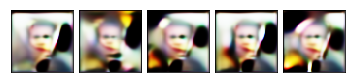

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: -0.00029547161915723016
Generator loss:     6.626183734220617


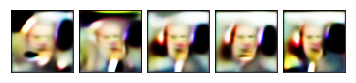

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: -0.014370116898242165
Generator loss:     6.057347297668457


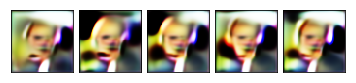

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: -0.005339245147564832
Generator loss:     9.92268565121819


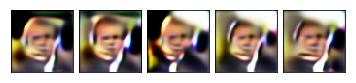

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.49it/s]
Discriminator loss: 0.03893971969099606
Generator loss:     8.609769119935876


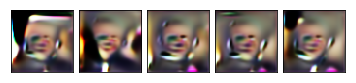

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.44it/s]
Discriminator loss: 0.096056257319801
Generator loss:     6.730131485882928


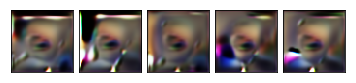

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 0.08519158950623344
Generator loss:     5.740005184622372


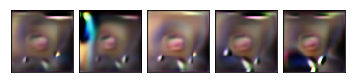

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.50it/s]
Discriminator loss: 0.03644390404224396
Generator loss:     6.692349966834573


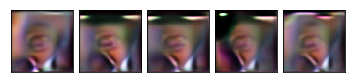

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 0.0598052207599668
Generator loss:     7.62394764844109


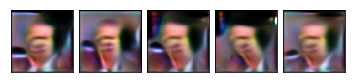

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 0.03218997751965242
Generator loss:     8.718012683531818


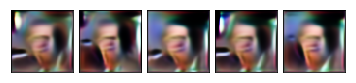

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.59it/s]
Discriminator loss: 0.11019610219142016
Generator loss:     9.26663485695334


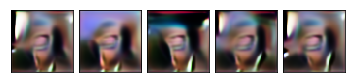

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: 0.03265893092269406
Generator loss:     8.66035673197578


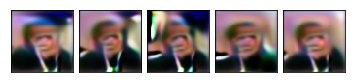

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 0.0040100063471233145
Generator loss:     8.009502663331872


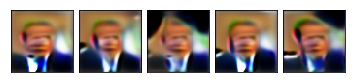

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.52it/s]
Discriminator loss: -0.13879421397167094
Generator loss:     9.3203044498668


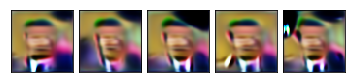

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: -0.03605940444942783
Generator loss:     8.582344952751608


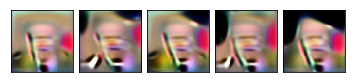

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 0.08603168585721184
Generator loss:     8.202338302836699


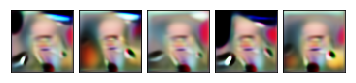

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 0.1287456227137762
Generator loss:     6.461713594548843


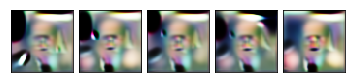

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: -0.1399045805720722
Generator loss:     9.011455031002269


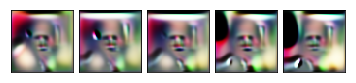

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.44it/s]
Discriminator loss: -0.10060867973986794
Generator loss:     15.94050816928639


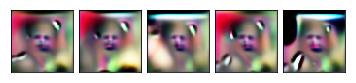

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.50it/s]
Discriminator loss: -0.0044250242850359745
Generator loss:     7.120770510505228


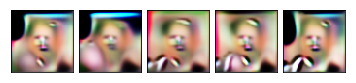

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.10it/s]
Discriminator loss: 0.18552147465593674
Generator loss:     8.751095126656924


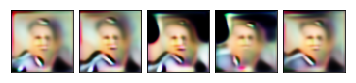

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
Discriminator loss: 0.10677134464768802
Generator loss:     7.543191236608169


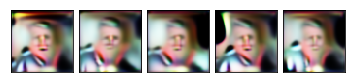

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
Discriminator loss: 0.347675128675559
Generator loss:     7.601417737848618


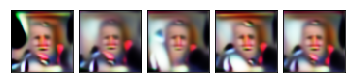

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.50it/s]
Discriminator loss: -0.026023197042591432
Generator loss:     6.73066837647382


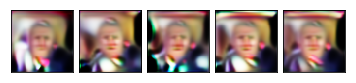

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: 0.10128249732010505
Generator loss:     7.389584737665513


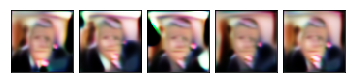

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.50it/s]
Discriminator loss: -0.030069149154074052
Generator loss:     8.218639738419476


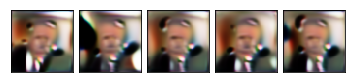

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: 0.05669032475527595
Generator loss:     7.831343370325425


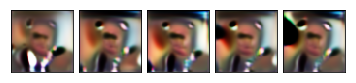

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.49it/s]
Discriminator loss: 0.10164742566206876
Generator loss:     8.54612263511209


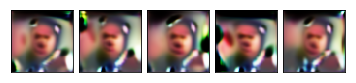

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: 0.027234021574258804
Generator loss:     10.128244119531969


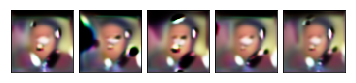

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.31it/s]
Discriminator loss: 0.2724829386262333
Generator loss:     12.497187684564029


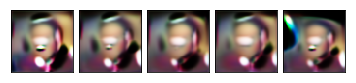

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
Discriminator loss: -0.020117213182589588
Generator loss:     13.319724812227136


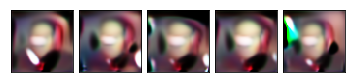

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 0.05115117907852811
Generator loss:     8.474001547869515


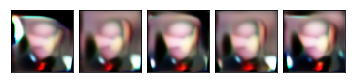

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 0.033022546592880696
Generator loss:     7.444225423476276


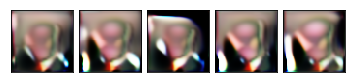

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: -0.05359134801170405
Generator loss:     8.438564384684843


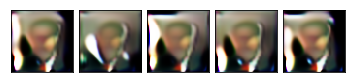

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: 0.08757808519636884
Generator loss:     7.029635611702414


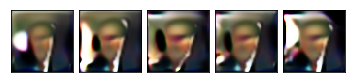

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: -0.0722563617369708
Generator loss:     8.983774381525377


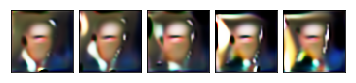

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: -0.03539140506044907
Generator loss:     8.86016009835636


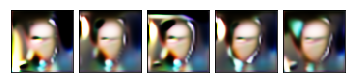

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: 0.1279124429120737
Generator loss:     11.456101165098303


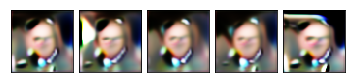

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: 0.1243582137805574
Generator loss:     6.261760010438807


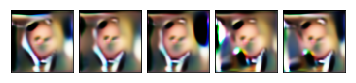

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 0.039988479193519146
Generator loss:     9.145460212931914


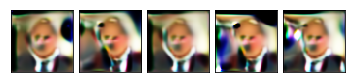

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 0.009376979268649045
Generator loss:     7.371882943546071


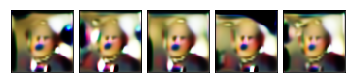

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: -0.13725585578119054
Generator loss:     9.266328755547018


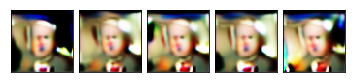

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: 0.021769460290670395
Generator loss:     9.903851705438951


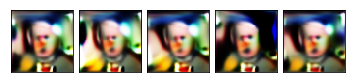

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: 0.10036879339638878
Generator loss:     11.025622087366441


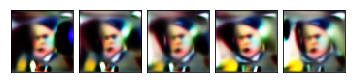

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 0.13979519268169122
Generator loss:     8.969646594103645


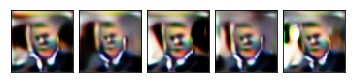

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
Discriminator loss: 0.022841988240971285
Generator loss:     10.262443921145271


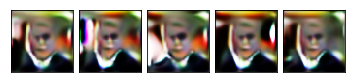

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:05<00:00,  2.81it/s]
Discriminator loss: 0.05740730157669853
Generator loss:     12.123285742367015


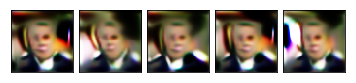

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.52it/s]
Discriminator loss: -0.17896830202902064
Generator loss:     13.873863472658044


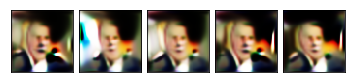

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 0.10434690424624611
Generator loss:     11.158083747414981


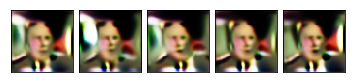

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.44it/s]
Discriminator loss: 0.011593268855529673
Generator loss:     12.158823013305664


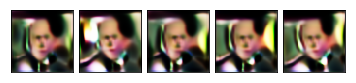

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.47it/s]
Discriminator loss: 0.014874162481111638
Generator loss:     11.237943761488971


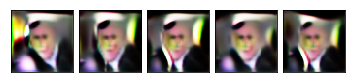

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: 0.08443098252310473
Generator loss:     14.037939464344698


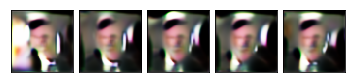

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.45it/s]
Discriminator loss: 0.040293567978283935
Generator loss:     8.355806238511029


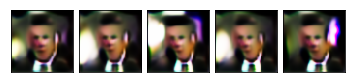

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.50it/s]
Discriminator loss: 0.06208418309688568
Generator loss:     8.385891858269186


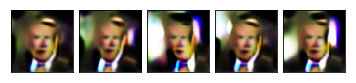

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.43it/s]
Discriminator loss: 0.15436158055330024
Generator loss:     6.914724924985101


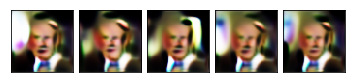

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


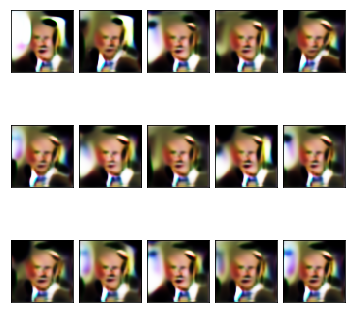

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


**Your answer:**
The objective of the discriminator is to learn from this supplied dataset how to distinguish real 
from fake signals. During this part of GAN training, only the discriminator parameters are updated. 

When the fake signal is presented to the discriminator, naturally it will be classified
as fake with a label close to 0.0. The optimizer computes generator parameter updates 
based on the presented label (that is, 1.0) and its own prediction to take into account this 
new training data. In other words, the discriminator has some level of doubts about its 
prediction and GAN takes that into consideration. This time, GAN will let the gradients 
back propagate from the last layer of the discriminator down to the first layer of the 
generator. However, in most practices, during this phase of training, the discriminator 
parameters are temporarily frozen. The generator uses the gradients to update its parameters and 
improve its ability to synthesize fake signals.



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


1.No, we shouldn't stop training solely based on the fact that the Generator loss is below the threshold.
When the generator loss is small, the generated fake pictures is more similar to the real pictures and thus
more likely to confuse the discriminator. However, the ultimate goal of GAN is to reduce discriminator loss while
decrease the generator loss at the same time in order to get a discriminator which distinguishes the fake pictures 
which are very similar to the real pictures

2.The discriminator got too strong relative to the generator. Beyond this point, the generator finds it almost
impossible to fool the discriminator, hence the increase in it's loss.




### Question 2

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


**Your answer:**

The GAN generates better pictures than VAE's blurry output.
However, VAE learns hidden representation of data better.

Autoencoders learn a given distribution comparing its input to its output, this is good for learning hidden 
representations of data, but is pretty bad for generating new data. Mainly because we learn an averaged 
representation of the data thus the output becomes pretty blurry.

Generative Adversarial Networks take an entirely different approach. They use another network (so-called Discriminator) 
to measure the distance between the generated and the real data. Basically what it does is distinguishing 
the real data from the generated. It receives some data as an input and returns a number between 0 and 1. 
0 meaning the data is fake and 1 meaning it is real. The generators goal then is learning to convince 
the Discriminator into believing it is generating real data.



